# **Sub-Picosecond Carrier Dynamics Explored using Doping Inhomogeneity within a Bayesian Framework**

Aurthors:

Ruqaiya Al-Abri (ruqaiya.al-abri@postgrad.manchester.ac.uk), Nawal Al-Amairi,Stephen Church, Patrick Parkinson (patrick.parkinson@manchester.ac.uk) 

***Department of Physics and Astronomy and the Photon Science Institute, University of Manchester, United Kingdom***

Conor Byrne, Alex Walton (alex.walton@manchester.ac.uk) 

***Department of Chemistry, University of Manchester, Oxford Road, Manchester, M13 9PL, United Kingdom***

Sudhakar Sivakumar, Martin Magnusson (martin.magnusson@ftf.lth.se)

***Department of Physics and NanoLund, Lund University, Box 118, SE-221 00, Sweden***

---
This notebook shows exploiting spread in parameters to reveal interesting correlations between controallble and functional parameters, and uncover sub-picosecond cooling dynamics of hot carriers. The notebook allows to manipulate and experiment the dataset used in this research paper at [small:202300053](https://doi.org/10.1002/smll.202300053).

# Dataset Format

The dataset assoicated with this research is available at [DOI:10.48420/20025791](https://figshare.manchester.ac.uk/articles/dataset/Sub-Picosecond_Carrier_Dynamics_Explored_using_Automated_High-Throughput_Studies_of_Doping_Inhomogeneity_within_a_Bayesian_Framework/20025791). The three files contains dataset summarized as follows:

- **full_fit_data.pkl**
    - contains the output parameters from the fitting the photoluminescence  spectra  
- **MCMC.pkl**
    - contains parameter distributions obtained from Markov-Chain Mont-Carlo model
- **wavelength.h5**
    - contains the experimental wavelength of the photoluminescence spectra 


In [7]:
# Required to download the dataset
import urllib.request as url
import os   
import zipfile
import progressbar
# Required to process the dataset
import numpy as np
import matplotlib as mpl 
# Required to visualize the dataset
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import pandas as pd
# random numbers
import random
# Pearson Correlation
from scipy.stats import pearsonr



---


# **Loading Data**

In [8]:
# Useful progressbar for downloading dataset
class MyProgressBar():
    def __init__(self):
        self.pbar = None

    def __call__(self, block_num, block_size, total_size):
        if not self.pbar:
            self.pbar=progressbar.ProgressBar(maxval=total_size)
            self.pbar.start()

        downloaded = block_num * block_size
        if downloaded < total_size:
            self.pbar.update(downloaded)
        else:
            self.pbar.finish()

# Download fitting parameters dataset
if not os.path.isfile('full_fit_data.h5'):
    print('Downloading fitting parameters dataset')
    url.urlretrieve('https://figshare.manchester.ac.uk/ndownloader/files/40219120','full_fit_data.h5', MyProgressBar())
else:
    print('Fitting parameters dataset already downloaded')
f_fit= h5py.File('full_fit_data.h5', 'r')

# Download MCMC dataset
if not os.path.isfile('MCMC.h5'):
    print('Downloading MCMC dataset')
    url.urlretrieve('https://figshare.manchester.ac.uk/ndownloader/files/40219039','MCMC.h5', MyProgressBar())
else:
    print('MCMC dataset already downloaded')

f_mcmc= h5py.File('MCMC.h5', 'r')

# Download wavelength
if not os.path.isfile('wavelength.h5'):
    print('Downloading wavelength')
    url.urlretrieve('https://figshare.manchester.ac.uk/ndownloader/files/40282090','wavelength.h5', MyProgressBar())
else:
    print('Fitting parameters dataset already downloaded')
f_wl= h5py.File('wavelength.h5', 'r')

Fitting parameters dataset already downloaded
MCMC dataset already downloaded
Fitting parameters dataset already downloaded


### **Open Files**

In [9]:
# Open PL dataset
f_fit.keys()
n1 = f_fit.get('Length')
print(f'The PL dataset contains {n1.shape[0]} structures')

# Open MCMC dataset
f_mcmc.keys()
n2 = f_mcmc.get('E')
print(f'The MCMC dataset contains {n2.shape[0]} structures')

# Open wavelength
wl = f_wl.get('wavelength')


The PL dataset contains 24819 structures
The MCMC dataset contains 1100000 structures




---


# **Show Data**
Description of the content of each file:



- **full_fit_data.h5f**

  Experimental data acquired for each nanowire 
    - PL_Spectra: photoluminescence spectra 
    - Length: lengths of nanowires
    
  Fitting parameters from PL fitting for conduction-band and split-off emissions
    - Energy: band-edge energy (eV)
    - Temperature: carrier temmperature (K)
    - PL_Area: area under PL peak 
    - Height: band-edge energy peak (photon/ev)

- **MCMC.h5f** 
  
  Posterior distributions from MCMC sampling
    - **E0**: Energy band-edge of intrinsic GaAs (eV)
    - **K**: Constant linking doping and redshift (eV.cm)
    - **log(S)**: Surface recombination velocity in logarithmic scale (cm/s)
    - **log(B)**: Bimolecular radiative constant in logarithmic scale (cm3/s)
    - **log(C)**: Auger constant in logarithmic scale (cm6/s)
    - **log(τ0)**: Initial cooling time in logarithmic scale (s) 
    - **T0**: Initial temperature after excitation (K)
    - **log(α)**: Scaling factor related to experimental conditions in logarithmic scale
    - **log(p)**: Hole density in in logarithmic scale (cm−3)
    - **d**: Nananowire diameter (nm)  

- **wavelength.h5f**

  - **wavelength**: Experimental wavelength of the photoluminescence spectra 
    
  








## **Filtering Data**

Some nanowires are weak emitters, therefore, the signal-to-noise ratio is very low resulting in bad fitting. Here we filter out data points based on weak PL emission, too high temperature, and large energy-band-edge.

In [10]:
# Extract Data
E_BE = np.array(f_fit['tp_E0_BE'])
T_BE = np.array(f_fit['tp_T_BE'])
PL_BE = np.array(f_fit['tp_beta_BE'])
E_SO = np.array(f_fit['tp_E0_SO'])
T_SO = np.array(f_fit['tp_T_SO'])
PL_SO = np.array(f_fit['tp_beta_SO'])
BE_integral = np.array(f_fit['BE_integral'])
SO_integral = np.array(f_fit['SO_integral'])
BE_component = np.array(f_fit['BE_component'])
SO_component = np.array(f_fit['SO_component'])
Spectra = list(np.array(f_fit['Spectra']).T)
one_peak_fit = list(np.array(f_fit['one_peak_fit']).T)
two_peak_fit = list(np.array(f_fit['two_peak_fit']).T)

# Filter out unphysical data
spectral_filters = [
    (PL_BE < 6e-16)&       # Remove v. large (cluster) signals
    (PL_SO < 0.119e-15)&   # Remove large (cluster) signals
    (E_BE < 1.405)&        # Remove end of range for E (high)
    (E_BE > 1.301)&        # Remove end of range for E (low)
    (E_SO < 1.799)&        # Limits on SO emission
    (E_SO > 1.671)&        # Limits on SO emission range
    (T_BE < 5450)&         # Remove end of range for T (high)
    (T_BE > 330)&          # Remove end of range for T (low)
    (T_SO > 305)&          # Remove end of range for T (low)
    (T_SO <700)]           # Remove end of range for T (high)

filter =np.array(spectral_filters) 
filter = np.squeeze(filter)
print(f'Keeping {np.sum(filter)} of {E_BE.shape}, removing {np.sum(1-filter)}');


Keeping 11487 of (24819,), removing 13332


**Helper Functions**


In [11]:
# Function to calcualte carrier lifetime using carrier temperature
def tau_T(T,tau_0,T0,TL=300):
    return np.maximum(-tau_0*np.log((T-TL)/T0),0)

# Function to calcualte doping using carrier energy
def doping(E,E0,K):
    return np.maximum(np.power(((E0 - E)/K),3),0)

# Energy (eV)
eV = 1239.74/np.array(wl)

wide_wl = np.linspace(500,1000,1000)
wide_eV = 1239.74/wide_wl

---

# **Visulaize Data**

## **PL spectrum with fit**

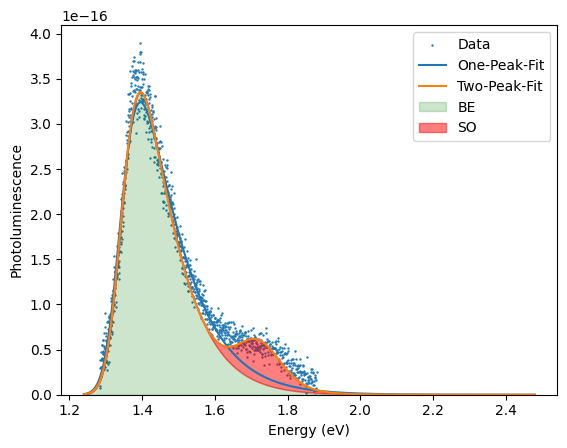

In [12]:
# Select NW index to show PL spectum with the fitting
index = 12; 
y = f_fit['Spectra'][filter][index,:]
plt.scatter(eV,y,s=0.5)

# Show fits
plt.plot(wide_eV,f_fit['one_peak_fit'][filter][index,:],'-');
plt.plot(wide_eV,f_fit['two_peak_fit'][filter][index,:],'-');

# Show components
plt.fill_between(wide_eV,f_fit['BE_component'][filter][index,:],0,color='g',alpha=0.2)
plt.fill_between(wide_eV,f_fit['two_peak_fit'][filter][index,:],f_fit['BE_component'][filter][index,:],color='r',alpha=0.5);

# Decoration
plt.xlabel('Energy (eV)');
plt.ylabel('Photoluminescence')
yl = plt.ylim()
plt.ylim([0,yl[1]])
plt.legend(['Data','One-Peak-Fit','Two-Peak-Fit','BE','SO']);

## **Histograms**

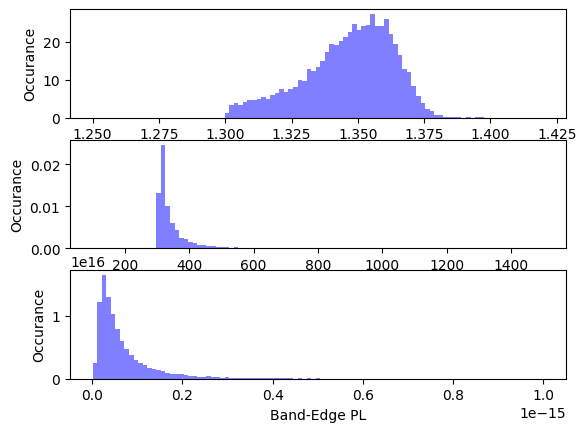

In [13]:
plt.subplot(3,1,1)
plt.hist(E_BE[filter],np.linspace(1.25, 1.42,100),density=True, fc =(0,0,1,0.5));
plt.xlabel('Band-Edge E (eV)'); plt.ylabel('Occurance')
plt.subplot(3,1,2)
plt.hist(T_SO[filter],np.linspace(100, 1500,100),density=True, fc =(0,0,1,0.5));
plt.xlabel('Split-off T (K)'); plt.ylabel('Occurance')
plt.subplot(3,1,3)
plt.hist(PL_BE[filter],np.linspace(1e-18, 1e-15,100),density=True, fc =(0,0,1,0.5));
plt.xlabel('Band-Edge PL'); plt.ylabel('Occurance');


---

# **Use Data from MCMC**

We can use data from MCMC sampling to study correlation between different posterior parameters.

Correlation p-value=0.66806265, rho=0.004


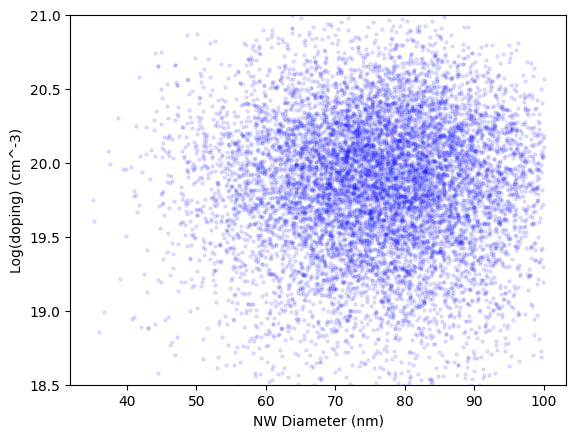

In [14]:
samples = f_mcmc
# Generate random numbers
xr = random.sample(range(1, 1100000), 10000)
d = np.array(samples['d'])[xr]
log_p = np.array(samples['log_p'])[xr]

# Plotting
plt.scatter(d, log_p, s=5, fc='b', alpha=0.1)
plt.xlabel('NW Diameter (nm)'); plt.ylabel('Log(doping) (cm^-3)')
plt.ylim([18.5,21]);


# Use Pearson correlation 
(r,p) = pearsonr(d,log_p)
print(f'Correlation p-value={p:.8f}, rho={r:.3f}')

Use mean of parameters from sampling to study correlation between doping and carrier lifetimes. The carrier lifetime is calculated using the following equation:

$\tau = \tau_{0} log(\frac{T-T_{L}}{T_{0}})$

where $\tau$ is the carrier lifetime, $\tau_{0}$ is the initial cooling time, $T$ is a carrier temperature, $T_{L}$ is lattice temperature, and $T_{0}$ is the initial carreir temperature.

<ipython-input-15-be9b1abbdb26>:13: RuntimeWarning: invalid value encountered in true_divide
  ratio = SO_integral/(SO_integral+BE_integral)


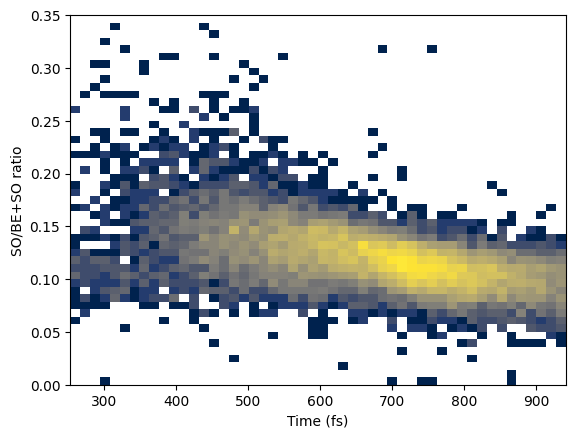

In [15]:
# Get constants
T0 = np.median(np.array(samples['T0']))
tau0 = np.median(np.array(samples['tau0'])*1e12)
TL = 300
# Use splitt-off T 
T = T_SO[filter]

# Calculate carrier lifetime
lifetime = tau_T(T,tau0,T0,TL)
f = (lifetime>0)

# Calculate ratio of split-off to total emission 
ratio = SO_integral/(SO_integral+BE_integral)
ratio = ratio[filter]

# Correlation between lifetime and ratio
plt.hist2d((lifetime[f]*1e3),ratio[f],
           (50,np.linspace(0,0.35)), 
           norm=mpl.colors.LogNorm(),cmap='cividis')

# Decorate
plt.xlabel("Time (fs)")
plt.ylabel('SO/BE+SO ratio');